In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from set_transformer.main import read_ogt_data
X_train, X_train_column_names, y_train, X_test, X_test_column_names, y_test, num_classes, categories_linspace = read_ogt_data()

print(len(categories_linspace))

ind_point = 15
file_names_cv = [f"prediction_probabilities_cross_valid_fold_0_SetTransformer_indPoints_{ind_point}", f"prediction_probabilities_cross_valid_fold_1_SetTransformer_indPoints_{ind_point}", f"prediction_probabilities_cross_valid_fold_2_SetTransformer_indPoints_{ind_point}", f"prediction_probabilities_cross_valid_fold_3_SetTransformer_indPoints_{ind_point}", f"prediction_probabilities_cross_valid_fold_4_SetTransformer_indPoints_{ind_point}"]




80


In [79]:
def calculate_r2(y_act, y_pred):
    y_act = np.array(y_act)
    y_pred = np.array(y_pred)
    # Calculate SS_res (Residual Sum of Squares)
    ss_res = np.sum((y_act - y_pred) ** 2)
    
    # Calculate SS_tot (Total Sum of Squares)
    y_mean = np.mean(y_act)
    ss_tot = np.sum((y_act - y_mean) ** 2)
    
    # Calculate R^2
    r_squared = 1 - (ss_res / ss_tot)
    
    print(f"R^2 for the line y = x: {r_squared:.2f}")    

In [80]:
# Read your dataframe (for example from a CSV file)
def read_and_plot(filename):
    df = pd.read_csv(f"set_transformer/resuls_SetTransformer/{filename}.csv",sep="\t")  # Replace with your file path
    y_act_to_temp = []
    for categ_i in df['y_actual']:
        mid_bin_temp = ((categories_linspace[categ_i-1] + categories_linspace[categ_i])/2)
        y_act_to_temp.append(mid_bin_temp)
    predict_to_temp = []
    for categ_i in df['prediction']:
        mid_bin_temp = ((categories_linspace[categ_i-1] + categories_linspace[categ_i])/2)
        predict_to_temp.append(mid_bin_temp)
    plt.scatter(y_act_to_temp, predict_to_temp, marker='o', alpha = 0.3, c = "tab:blue", s=13)#, linestyle='-', color='b')
    
    return min(y_act_to_temp), max(y_act_to_temp), min(predict_to_temp), max(predict_to_temp), y_act_to_temp, predict_to_temp

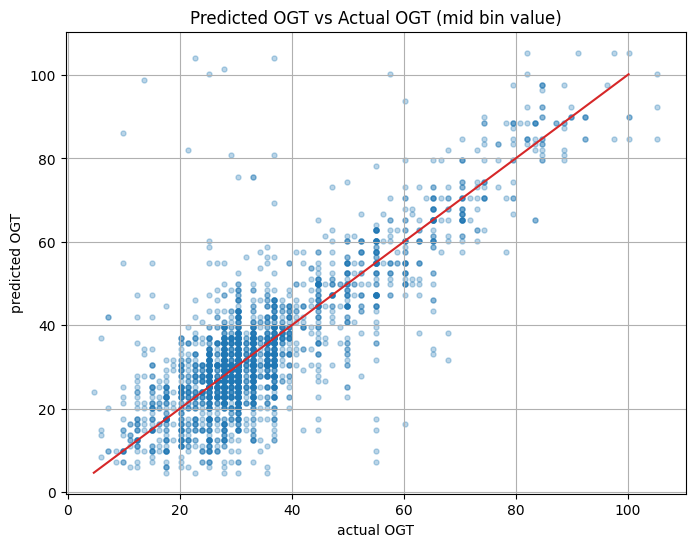

R^2 for the line y = x: 0.61


In [81]:
y_act_to_temp_tot = []
predict_to_temp_tot = []

plt.figure(figsize=(8, 6))
plt.grid(True)
for file in file_names_cv:
    x_min, x_max, y_min, y_max, y_act_to_temp, predict_to_temp = read_and_plot(file)
    y_act_to_temp_tot += y_act_to_temp
    predict_to_temp_tot += predict_to_temp
plt.plot([x_min,x_max],[x_min,x_max], c = "tab:red")
plt.title('Predicted OGT vs Actual OGT (mid bin value)')
plt.xlabel('actual OGT')
plt.ylabel('predicted OGT')

plt.show()

calculate_r2(y_act_to_temp_tot, predict_to_temp_tot)

R²: 0.69


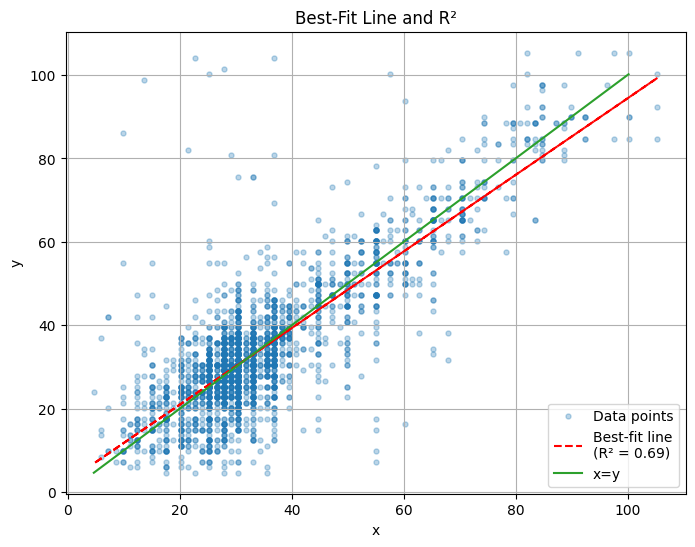

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Example data points
x = np.array(y_act_to_temp_tot).reshape(-1, 1)  # Reshaped to fit sklearn's requirement
y = np.array(predict_to_temp_tot)

# Fit a linear regression model
model = LinearRegression()
model.fit(x, y)

# Get predictions for the best-fit line
y_pred = model.predict(x)

# Calculate R²
r2 = r2_score(y, y_pred)
print(f"R²: {r2:.2f}")
plt.figure(figsize=(8, 6))
# Plot the data points
plt.scatter(x, y, label='Data points', marker='o', alpha = 0.3, c = "tab:blue", s=13)

# Plot the best-fit line
plt.plot(x, y_pred, color='red', linestyle='--', label=f'Best-fit line\n(R² = {r2:.2f})')


plt.plot([x_min,x_max],[x_min,x_max], c = "tab:green", label = "x=y")


# Add labels, legend, and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Best-Fit Line and R²')
plt.legend()
plt.grid()

# Display the plot
plt.show()

In [52]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.decomposition import PCA

#X_val = df_keggs.values

scaler = MaxAbsScaler()
# Fit and transform the data
X_val = scaler.fit_transform(X_train)

n_compon=2
# Run PCA on the X-data
pca = PCA(n_components=n_compon)
X_train_pca = pca.fit_transform(X_val)

explained_variance_ratio = pca.explained_variance_ratio_

plt.figure()
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], alpha=0.3, s = 10, c=y_train, cmap='brg')#, cmap=listed_cmap)
plt.xlabel(f"PC 1; var = {round(explained_variance_ratio[0],2)}")
plt.ylabel(f"PC 2; var = {round(explained_variance_ratio[1],2)}")
plt.colorbar()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [6]:
from sklearn.manifold import TSNE

# Initialize and apply t-SNE
tsne = TSNE(n_components=2, perplexity=50, learning_rate=100, max_iter=3000, init='pca') 
X_tsne = tsne.fit_transform(X_train) 

print(X_tsne.shape)

(3001, 2)


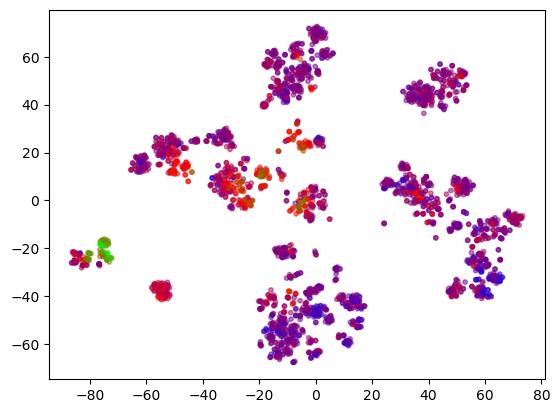

In [7]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.5, s = 10, c=y_train, cmap='brg')